In [2]:
import multiprocessing
multiprocessing.cpu_count()

16

In [3]:
import numpy as np
np.version.version

'1.20.0'

In [4]:
from osgeo import osr
import pdal
from string import Template
#import numpy as np

In the pipeline below we select 35m as the limit on ```HeightAboveGround``` because it is a reasonable value and it is the 0.999 quantile on a tif made with no limit.

In [5]:
def make_pipe(bbox, chm_path, srs='EPSG:3857'):
    '''Creates, validates and then returns the pdal pipeline
    
    Arguments:
    bbox     -- Bounding box in srs coordintes (default srs is EPSG:3857),
                in the form: ([xmin, xmax], [ymin, ymax]).
    chm_path -- String - Path where the CHM shall be saved. Must include .tif exstension.
    srs      -- String - EPSG identifier for srs  being used. Defaults to EPSG:3857
                because that is what ept files tend to use.
    '''
    
    t = Template('''
    {
        "pipeline": [
            {
            "bounds": "${scaled_bbox}",
            "filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_CA_LosAngeles_2016_LAS_2018/ept.json",
            "type": "readers.ept",
            "tag": "readdata",
            "spatialreference":"${srs}"
            },
            {
            "type":"filters.outlier",
            "method":"radius",
            "radius":1.0,
            "min_k":4
            },
            {
            "type":"filters.range",
            "limits":"returnnumber[1:1]"
            },
            {
            "type": "filters.reprojection",
            "in_srs":"${srs}",
            "out_srs": "EPSG:26911"
            },
            {
            "type":"filters.smrf",
            "scalar":1.2,
            "slope":0.2,
            "threshold":0.45,
            "window":16.0
            },
            {
            "type":"filters.hag_delaunay"
            },
            {
            "type":"filters.range",
            "limits":"HeightAboveGround[0:35]"
            },
            {
            "filename": "${chm_path}",
            "gdalopts": "tiled=yes,     compress=deflate",
            "nodata": -9999,
            "output_type": "idw",
            "resolution": 1,
            "type": "writers.gdal",
            "window_size": 6,
            "dimension": "HeightAboveGround"
            }
        ]
    }''')

    pipe = t.substitute(scaled_bbox=bbox, srs=srs, chm_path=chm_path)
    pipeline = pdal.Pipeline(pipe)
    if pipeline.validate():
        return(pipeline)
    else:
        raise Exception('Bad pipeline (sorry to be so ambigous)!')

In [6]:
xmin = -118.51765140181836
ymin = 33.995146776023624
xmax = -118.44351271585195
ymax = 34.050617079693275

# define transform from EPSG:4326 to EPSG:3857
old_crs = osr.SpatialReference() 
old_crs.ImportFromEPSG(4326) 
new_crs = osr.SpatialReference() 
new_crs.ImportFromEPSG(3857)
transform = osr.CoordinateTransformation(old_crs,new_crs)

# transform bbox points
xmin, ymin, zmin = transform.TransformPoint(ymin, xmin)
xmax, ymax, zmax = transform.TransformPoint(ymax, xmax)

#make tiles
n = 10
dx = abs(xmin - xmax) / n
dy = abs(ymin - ymax) / n




In [7]:


x = xmin
xs = []
while x < xmax:
    xs.append([x, x + dx])
    x = x + dx
if x < xmax:
    xs.append([x, xmax])

y = ymin
ys = []
while y < ymax:
    ys.append([y, y + dy])
    y = y + dy
if y < ymax:
    ys.append([y, ymax])

    
bxs = []
for x in xs:
    for y in ys:
        bbox = (x, y)
        bxs.append(bbox)



In [8]:
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import os

In [9]:
@delayed
def tilez(i, bbox):
    chm_path = f'{tmp}/chm{i}.tif'
    pipeline = make_pipe(bbox, chm_path)
    try:
        count = pipeline.execute()
    except RuntimeError as e:
        print(f'This happened --{e}-- on the bbox {bbox}')
    except Exception as e:
        print(f'pipeline failed on this {bbox} due to \n{e}')
    
    

# make a variable for its path
home = os.path.expanduser('~')
tmp = f'{home}/tmp'
    
results = []
for i, bbox in enumerate(bxs):
    results.append(tilez(i, bbox))

with ProgressBar():
    computed_results = compute(*results)

[                                        ] | 0% Completed |  0.7sThis happened All points collinear on the bbox ([-13190023.371757178, -13189198.06368019], [4034110.627024999, 4034855.65848512])
This happened All points collinear on the bbox ([-13192499.295988139, -13191673.987911152], [4034110.627024999, 4034855.65848512])
[#                                       ] | 3% Completed |  7min  1.0sThis happened writers.gdal: Grid width or height is too large. Width and height are limited to 2147483647 cells.Try setting bounds or increasing resolution. on the bbox ([-13192499.295988139, -13191673.987911152], [4028150.3753440287, 4028895.40680415])
[###############                         ] | 38% Completed | 58min 34.9sThis happened writers.gdal: Grid width or height is too large. Width and height are limited to 2147483647 cells.Try setting bounds or increasing resolution. on the bbox ([-13193324.604065126, -13192499.295988139], [4028895.40680415, 4029640.4382642712])
[################      

In [10]:
import gdal
files = [tmp + '/' + f for f in os.listdir(tmp) if f.endswith('.tif')]
vrt = gdal.BuildVRT(f'{tmp}/santa_monica_chm.vrt', files)
mosaic_sMonica = gdal.Translate(f'{tmp}/santa_monica_mosaic.tiff', vrt)

In [11]:
import rasterio as rio
import matplotlib.pyplot as plt

In [12]:
with rio.open(f'{tmp}/santa_monica_mosaic.tiff') as tif:
    arr = tif.read()
 

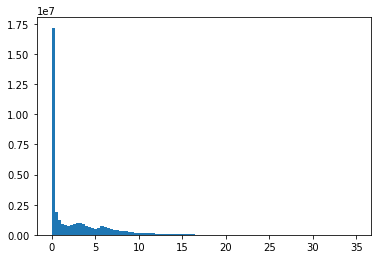

In [13]:
plt.hist(arr[arr>=0], bins=100);

In [14]:
np.quantile(arr, 0.999)

25.101731953291043